In this Notebook, we've experimented with the Support Vector Machine (SVM) algorithm to challenge our current deployed classifier in the classification problem of predicting the *Weakest Link*.

# 1. Configuration

## 1.1 Import Libraries

In [1]:
import sys
import pandas as pd
import seaborn as sns
import matplotlib as matplot
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy

print("Python ver: {}".format(sys.version))
print("Numpy ver: {}".format(np.__version__))
print("Pandas ver: {}".format(pd.__version__))
print("MatPlotLib ver: {}".format(matplot.__version__))
print("SeaBorn ver: {}".format(sns.__version__))
print("StatsModel ver: {}".format(sm.__version__))
print("Scipy ver: {}".format(scipy.__version__))
print("SkLearn ver: {}".format(sklearn.__version__))

Python ver: 3.9.2 (default, Feb 24 2021, 13:26:09) 
[Clang 12.0.0 (clang-1200.0.32.29)]
Numpy ver: 1.19.5
Pandas ver: 1.1.4
MatPlotLib ver: 3.3.3
SeaBorn ver: 0.11.1
StatsModel ver: 0.12.1
Scipy ver: 1.5.4
SkLearn ver: 0.24.1


## 1.2 Introduce helper functions

In [2]:
def displayPredictors(df):
    print("Number of predictors: {}".format(len(df.columns.values)))
    for i in range(0,len(df.columns.values)):
        print("{}.'{}'".format(i+1,df.columns.values[i]), end=', ')
        
def heatMap(df,max=1,min=-1,triangleMask=False,showDiameter=True,width=11,height=9):
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(width, height))

    # Generate a custom diverging colormap
    cmap = "RdPu"

    # Generate a mask for the upper triangle
    if triangleMask:
        if showDiameter :
            mask = np.triu(np.ones_like(df, dtype=bool),1)
        else:
            mask = np.triu(np.ones_like(df, dtype=bool))
    else:
        mask = None
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(df, mask=mask, cmap=cmap, vmax=max, center=(max+min)/2, vmin=min,
                square=True, annot=True, linewidths=.2, cbar_kws={"shrink": .5})

    # Show the plot
    plt.show()
    
    
def scatterPlot(df,xColumn,yColumn,xLabel,yLabel,width=9,height=6,pearson=False):
    fig, ax = plt.subplots(figsize=(width,height))
    
    sns.regplot(y=yColumn, x=xColumn, data=df,ax=ax)
    
    if xLabel:
        plt.xlabel(xLabel)
    if yLabel:
        plt.ylabel(yLabel)
        
    plt.show()
    
    if pearson:
        r,p = scipy.stats.pearsonr(df[xColumn], df[yColumn])
        print("r = {} , p < {}".format(round(r, 3),p))

def pieChart(values,labels,width=7,height=7):
    f, ax = plt.subplots(figsize=(width, height))
    ax = plt.pie(values, labels=labels, wedgeprops={'edgecolor': 'black'}, autopct='%1.f%%', explode=(values*0)+0.05, shadow=True)
    plt.show()
        
def checkColumnsTypes(df):
    types = pd.DataFrame({"Name":df.columns})
    quantitative = df.dtypes[df.dtypes!="object"]
    qualitative = df.dtypes[df.dtypes=="object"]
    types["Type"] = np.where(df[types['Name']].dtypes!="object", "Quantitative", "Qualitative")
    types["isQuantitative"] = np.where(df[types['Name']].dtypes!="object", True, False)
    return types ,types["Type"].value_counts()
    
def checkCorrectness(df,originalLabel,predictedLabel):
    correct = len(df[(df[originalLabel] == df[predictedLabel])])
    incorrect = len(df) - correct
    return (correct,incorrect,(correct*100/(correct+incorrect)))

def findCorrelatedColumns(df,minThreshold):
    corr = df.corr()
    pairs = []

    for i in corr.columns:
        for j in corr[i][abs(corr[i])>=minThreshold].index:
            if i != j:
                pairs.append({"C1":i,"C2":j,"Corr":corr[i][j]})
    return pairs

def findCorrelatedColumns2(df,minThreshold):
    corr = df.corr()
    pairs = []

    for i in corr.columns:
        for j in corr[i][abs(corr[i])>=minThreshold].index:
            if i != j:
                pairs.append(i)
    return pairs

def findHighCorrelation(df,minThreshold,target):
    corr = df.corr()
    pairs = []

    for j in corr[target][abs(corr[target])>=minThreshold].index:
        if target != j:
            pairs.append({"Name":j,"Corr":corr[target][j]})
    return pairs

def checkCorrectness(df,originalLabel,predictedLabel):
    correct = len(df[(df[originalLabel] == df[predictedLabel])])
    incorrect = len(df) - correct
    return (correct,incorrect,(correct*100/(correct+incorrect)))

## 1.3 Set pre configurations

In [3]:
import warnings

# Set Seaborn theme
sns.set_theme(color_codes=True)

# Disable warnings
warnings.simplefilter("ignore")

# 2. Data Preparation

## 2.1 Load the data

In [4]:
try:
    data = pd.read_csv('../../datasets/AimoScoreWeakLinks.csv')
    data = data.drop(columns=['Unnamed: 0', 'AimoScore'])
except IOError as e:
    print(e)

## 2.2 Split it into training and test sets

In [5]:
from sklearn.model_selection import train_test_split

trainingPercent = 0.9

y_train, y_test, X_train, X_test  = train_test_split(data["WeakLinks"], data.drop(columns=["WeakLinks"]), train_size = trainingPercent, random_state=0)

# 3. Create the models

## 3.1 Standard model

In [6]:
from sklearn.svm import SVC

svc = SVC()
svc.fit(X_train, y_train)

SVC()

In [7]:
print('Number of support vectors: ', svc.support_.size)
svc.support_

Number of support vectors:  1617


array([  15,   25,   33, ..., 1838, 1855, 1875], dtype=int32)

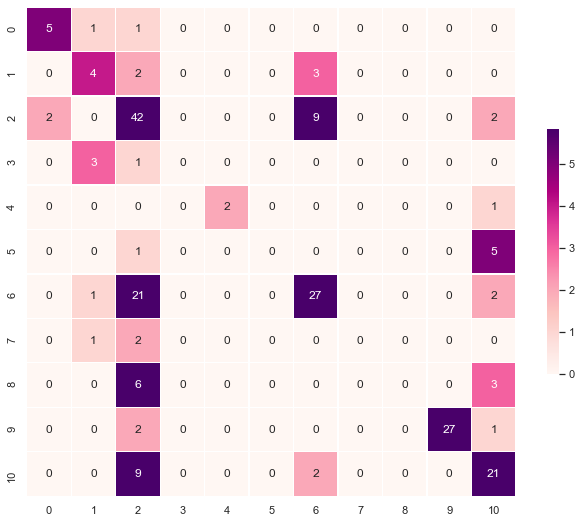

In [8]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred_svc = svc.predict(X_test)

confusion_matrix_svc = pd.DataFrame(
    confusion_matrix(y_test, y_pred_svc))

pivot = np.mean(confusion_matrix_svc.max()/2)
heatMap(confusion_matrix_svc, max=pivot, min=0)

In [9]:
print(classification_report(y_test, y_pred_svc))

                              precision    recall  f1-score   support

        ExcessiveForwardLean       0.71      0.71      0.71         7
                 ForwardHead       0.40      0.44      0.42         9
          LeftArmFallForward       0.48      0.76      0.59        55
 LeftAsymmetricalWeightShift       0.00      0.00      0.00         4
        LeftKneeMovesOutward       1.00      0.67      0.80         3
       LeftShoulderElevation       0.00      0.00      0.00         6
         RightArmFallForward       0.66      0.53      0.59        51
RightAsymmetricalWeightShift       0.00      0.00      0.00         3
        RightKneeMovesInward       0.00      0.00      0.00         9
       RightKneeMovesOutward       1.00      0.90      0.95        30
      RightShoulderElevation       0.60      0.66      0.63        32

                    accuracy                           0.61       209
                   macro avg       0.44      0.42      0.43       209
                we

## 3.2 Linear kernel

In [10]:
from sklearn.model_selection import GridSearchCV

params = {
    'C': [0.001, 0.01, 0.1, 1, 5, 10, 25, 50]
}

# 10-fold cross validation (cv=10) 
cv_svm_linear_first = GridSearchCV(SVC(kernel='linear'), params, cv=10)
cv_svm_linear_first.fit(X_train, y_train)

print(cv_svm_linear_first.best_params_)
c = cv_svm_linear_first.best_params_['C']
pd.DataFrame(cv_svm_linear_first.cv_results_)

{'C': 25}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.127257,0.017046,0.013586,0.000619,0.001,{'C': 0.001},0.303191,0.303191,0.303191,0.303191,0.303191,0.303191,0.310160,0.310160,0.310160,0.304813,0.305444,0.003124,8
1,0.122456,0.001669,0.013261,0.000202,0.01,{'C': 0.01},0.420213,0.398936,0.409574,0.409574,0.409574,0.404255,0.427807,0.422460,0.411765,0.422460,0.413662,0.008700,7
2,0.116740,0.019980,0.013561,0.002238,0.1,{'C': 0.1},0.494681,0.478723,0.446809,0.436170,0.478723,0.446809,0.491979,0.465241,0.497326,0.470588,0.470705,0.020565,6
3,0.139205,0.001997,0.015714,0.000830,1,{'C': 1},0.563830,0.537234,0.494681,0.500000,0.585106,0.569149,0.550802,0.524064,0.577540,0.577540,0.547995,0.031086,5
4,0.153320,0.022140,0.014008,0.002223,5,{'C': 5},0.574468,0.558511,0.500000,0.531915,0.606383,0.574468,0.540107,0.524064,0.566845,0.609626,0.558639,0.033375,2
5,0.144865,0.004212,0.011135,0.000115,10,{'C': 10},0.585106,0.547872,0.521277,0.526596,0.601064,0.579787,0.529412,0.497326,0.550802,0.593583,0.553283,0.033310,4
6,0.212976,0.005779,0.011151,0.000661,25,{'C': 25},0.622340,0.531915,0.500000,0.547872,0.617021,0.569149,0.540107,0.508021,0.582888,0.604278,0.562359,0.041573,1
7,0.336638,0.021534,0.011024,0.000516,50,{'C': 50},0.622340,0.531915,0.494681,0.537234,0.601064,0.569149,0.540107,0.497326,0.577540,0.604278,0.557563,0.042146,3


In [11]:
# Testing a more narrow range

params = {
    'C': [c - 1, c - 0.5, c, c + 0.5, c + 1]
}

# 10-fold cross validation (cv=10) 
cv_svm_linear_second = GridSearchCV(SVC(kernel='linear'), params, cv=10)
cv_svm_linear_second.fit(X_train, y_train)

print(cv_svm_linear_second.best_params_)
c = cv_svm_linear_second.best_params_['C']
pd.DataFrame(cv_svm_linear_second.cv_results_)

{'C': 25}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.211671,0.011750,0.010811,0.000142,24,{'C': 24},0.632979,0.537234,0.5,0.547872,0.617021,0.563830,0.534759,0.502674,0.582888,0.604278,0.562354,0.043829,2
1,0.204877,0.006677,0.010918,0.000256,24.5,{'C': 24.5},0.622340,0.537234,0.5,0.547872,0.617021,0.563830,0.534759,0.502674,0.582888,0.604278,0.561290,0.042201,4
2,0.206515,0.005635,0.010838,0.000256,25,{'C': 25},0.622340,0.531915,0.5,0.547872,0.617021,0.569149,0.540107,0.508021,0.582888,0.604278,0.562359,0.041573,1
3,0.209274,0.007161,0.010972,0.000435,25.5,{'C': 25.5},0.622340,0.526596,0.5,0.542553,0.617021,0.563830,0.545455,0.508021,0.582888,0.604278,0.561298,0.041897,3
4,0.216955,0.010029,0.010828,0.000213,26,{'C': 26},0.622340,0.531915,0.5,0.542553,0.611702,0.569149,0.540107,0.508021,0.577540,0.604278,0.560761,0.040861,5


In [12]:
svm_linear = SVC(C=c, kernel='linear')
svm_linear.fit(X_train, y_train)

print('Number of support vectors: ', svm_linear.support_.size)
svm_linear.support_

Number of support vectors:  1449


array([  15,   25,   33, ..., 1831, 1838, 1875], dtype=int32)

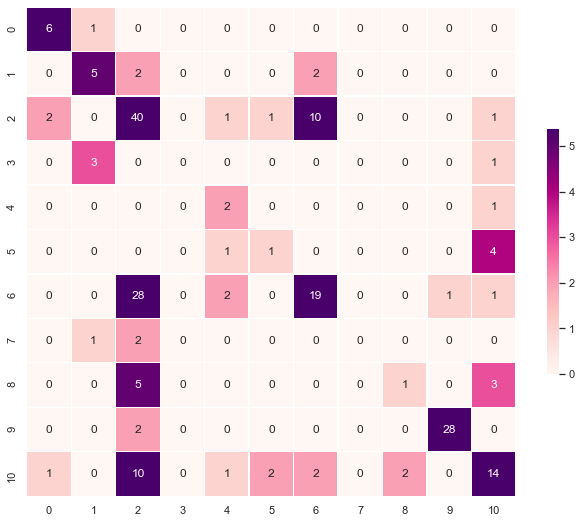

In [13]:
y_pred_svm_linear = svm_linear.predict(X_test)

confusion_matrix_svm_linear = pd.DataFrame(
    confusion_matrix(y_test, y_pred_svm_linear))

pivot = np.mean(confusion_matrix_svm_linear.max()/2)
heatMap(confusion_matrix_svm_linear,max=pivot,min=0)

In [14]:
print(classification_report(y_test, y_pred_svm_linear))

                              precision    recall  f1-score   support

        ExcessiveForwardLean       0.67      0.86      0.75         7
                 ForwardHead       0.50      0.56      0.53         9
          LeftArmFallForward       0.45      0.73      0.56        55
 LeftAsymmetricalWeightShift       0.00      0.00      0.00         4
        LeftKneeMovesOutward       0.29      0.67      0.40         3
       LeftShoulderElevation       0.25      0.17      0.20         6
         RightArmFallForward       0.58      0.37      0.45        51
RightAsymmetricalWeightShift       0.00      0.00      0.00         3
        RightKneeMovesInward       0.33      0.11      0.17         9
       RightKneeMovesOutward       0.97      0.93      0.95        30
      RightShoulderElevation       0.56      0.44      0.49        32

                    accuracy                           0.56       209
                   macro avg       0.42      0.44      0.41       209
                we

### Results

As the results show, using linear kernel, the best accuracy we can achieve with SVC (linear kernel) is still only slightly better than random guessing and therefore, not a predictive performance we're satisfied with.

## 3.3 Radial Kernel

In [15]:
params = {
    'C': [0.1, 0.5, 1, 2, 5, 10, 20, 30],
    'gamma': [000.1, 00.1, 0.1, 0.5, 1, 2, 3, 4, 5]
}

cv_svm_radial_first = GridSearchCV(SVC(kernel='rbf'), params, cv=10)
cv_svm_radial_first.fit(X_train, y_train)
c = cv_svm_radial_first.best_params_['C']
gamma = cv_svm_radial_first.best_params_['gamma']
print(cv_svm_radial_first.best_params_)

{'C': 2, 'gamma': 1}


In [16]:
# Testing a more narrow range

params = {
    'C': [c - 1, c - 0.5, c, c + 0.5, c + 1],
    'gamma': [gamma - 1, gamma - 0.5, gamma, gamma + 0.5, gamma + 1]
}

cv_svm_radial_second = GridSearchCV(SVC(kernel='rbf'), params, cv=10)
cv_svm_radial_second.fit(X_train, y_train)
c = cv_svm_radial_second.best_params_['C']
gamma = cv_svm_radial_second.best_params_['gamma']
print(cv_svm_radial_second.best_params_)

{'C': 2, 'gamma': 1}


In [17]:
svm_radial = SVC(C=c, kernel='rbf',gamma=gamma)
svm_radial.fit(X_train, y_train)

print('Number of support vectors: ', svm_radial.support_.size)
svm_radial.support_

Number of support vectors:  1635


array([  15,   25,   33, ..., 1838, 1855, 1875], dtype=int32)

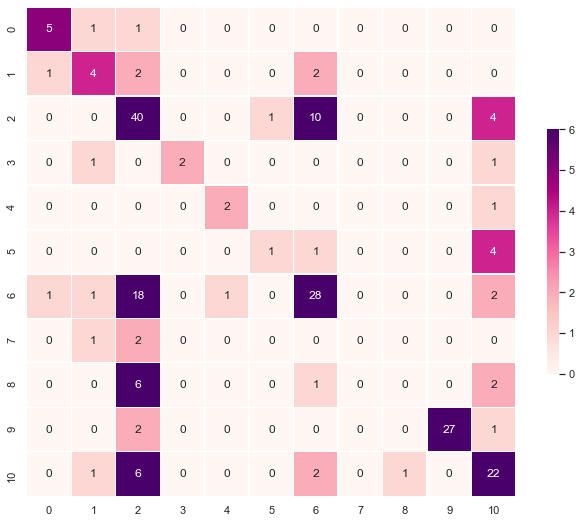

In [18]:
y_pred_svm_radial = svm_radial.predict(X_test)

confusion_matrix_svm_radial = pd.DataFrame(
    confusion_matrix(y_test, y_pred_svm_radial))

pivot = np.mean(confusion_matrix_svm_radial.max()/2)
heatMap(confusion_matrix_svm_radial,max=pivot,min=0)

In [19]:
print(classification_report(y_test, y_pred_svm_radial))

                              precision    recall  f1-score   support

        ExcessiveForwardLean       0.71      0.71      0.71         7
                 ForwardHead       0.44      0.44      0.44         9
          LeftArmFallForward       0.52      0.73      0.61        55
 LeftAsymmetricalWeightShift       1.00      0.50      0.67         4
        LeftKneeMovesOutward       0.67      0.67      0.67         3
       LeftShoulderElevation       0.50      0.17      0.25         6
         RightArmFallForward       0.64      0.55      0.59        51
RightAsymmetricalWeightShift       0.00      0.00      0.00         3
        RightKneeMovesInward       0.00      0.00      0.00         9
       RightKneeMovesOutward       1.00      0.90      0.95        30
      RightShoulderElevation       0.59      0.69      0.64        32

                    accuracy                           0.63       209
                   macro avg       0.55      0.49      0.50       209
                we

The accuracy of the radial model is around 63% which is a lot better than the linear kernel, but still far from perfect.

## 3.4 Polynomial Kernel

In [20]:
params = {
    'C': [0.1, 0.5, 1, 2, 5, 10, 25, 50],
    'gamma': [0.01, 0.1, 0.5, 1, 2, 5],
    'degree':[2, 3, 4, 5]
}

cv_svm_polynomial_first = GridSearchCV(SVC(kernel='poly'), params, cv=10)
cv_svm_polynomial_first.fit(X_train, y_train)
c = cv_svm_polynomial_first.best_params_['C']
gamma = cv_svm_polynomial_first.best_params_['gamma']
degree = cv_svm_polynomial_first.best_params_['degree']
print(cv_svm_polynomial_first.best_params_)

{'C': 0.5, 'degree': 2, 'gamma': 1}


In [21]:
# Testing a more narrow range

params = {
    'C': [c - 1, c - 0.5, c, c + 0.5, c + 1],
    'gamma': [gamma - 1, gamma - 0.5, gamma, gamma + 0.5, gamma + 1],
    'degree': [degree - 1, degree - 0.5, degree, degree + 0.5, degree + 1]
}

cv_svm_polynomial_second = GridSearchCV(SVC(kernel='poly'), params, cv=10)
cv_svm_polynomial_second.fit(X_train, y_train)
c = cv_svm_polynomial_second.best_params_['C']
gamma = cv_svm_polynomial_second.best_params_['gamma']
degree = cv_svm_polynomial_second.best_params_['degree']
print(cv_svm_polynomial_second.best_params_)

{'C': 0.5, 'degree': 2, 'gamma': 1}


In [22]:
svm_polynomial = SVC(C=c, kernel='poly', degree=degree ,gamma = gamma)
svm_polynomial.fit(X_train, y_train)

print('Number of support vectors: ', svm_polynomial.support_.size)

Number of support vectors:  1468


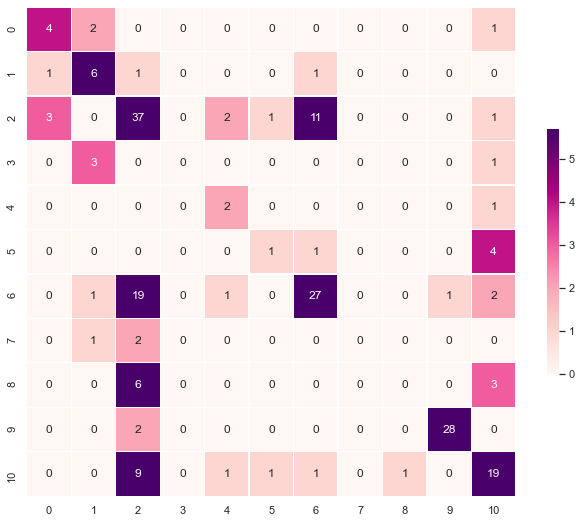

In [23]:
y_pred_svm_polynomial = svm_polynomial.predict(X_test)

confusion_matrix_svm_polynomial = pd.DataFrame(
    confusion_matrix(y_test, y_pred_svm_polynomial))

pivot = np.mean(confusion_matrix_svm_polynomial.max()/2)
heatMap(confusion_matrix_svm_polynomial,max=pivot,min=0)

In [24]:
print(classification_report(y_test, y_pred_svm_polynomial))

                              precision    recall  f1-score   support

        ExcessiveForwardLean       0.50      0.57      0.53         7
                 ForwardHead       0.46      0.67      0.55         9
          LeftArmFallForward       0.49      0.67      0.56        55
 LeftAsymmetricalWeightShift       0.00      0.00      0.00         4
        LeftKneeMovesOutward       0.33      0.67      0.44         3
       LeftShoulderElevation       0.33      0.17      0.22         6
         RightArmFallForward       0.66      0.53      0.59        51
RightAsymmetricalWeightShift       0.00      0.00      0.00         3
        RightKneeMovesInward       0.00      0.00      0.00         9
       RightKneeMovesOutward       0.97      0.93      0.95        30
      RightShoulderElevation       0.59      0.59      0.59        32

                    accuracy                           0.59       209
                   macro avg       0.39      0.44      0.40       209
                we

# 4. Results

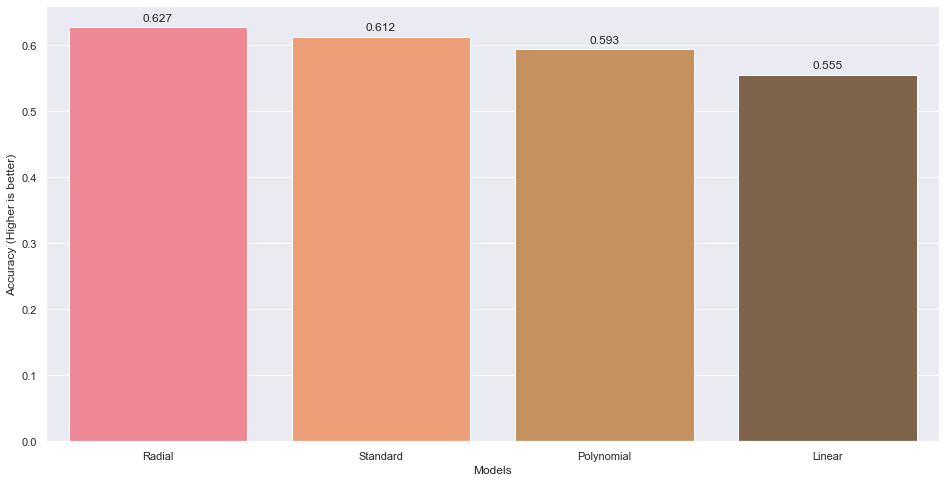

In [37]:
results = pd.DataFrame({
    "Accuracy":[
        classification_report(y_test, y_pred_svc, output_dict=True)['accuracy'],
        classification_report(y_test, y_pred_svm_linear, output_dict=True)['accuracy'],
        classification_report(y_test, y_pred_svm_radial, output_dict=True)['accuracy'],
        classification_report(y_test, y_pred_svm_polynomial, output_dict=True)['accuracy']
    ],
    "Models":[
        "Standard",
        "Linear",
        "Radial",
        "Polynomial"
    ]
})

results = results.sort_values("Accuracy", ascending=False)

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(16,8))

cplot = sns.barplot(data=results, x="Models", y="Accuracy",ax=ax, palette="spring_d")

for p in cplot.patches:
    cplot.annotate(format(p.get_height(), '.3f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

# Add labels to plot
plt.xlabel("Models")
plt.ylabel("Accuracy (Higher is better)")

plt.show()